In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Rescaling, RandomFlip, RandomRotation
import numpy as np
from collections import OrderedDict
import time
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
pre_lr_shape = (128, 128)         # Low resolution image height, width
pre_hr_shape = (1024, 1024)       # High resolution image height, width
lr_shape = (32, 32)
hr_shape = (128, 128)
channels = 3                # Number of Image channels
epoch = 0                   # If starting from middle, set epoch to where it was paused
max_epoch = 20             # Number of epochs to train the model
lr_g = 0.00001                 # Learning rate for Adam Optimizer
lr_d = 0.0001                 # Learning rate for Adam Optimizer
b1 = 0.5                    # Adam first moment decay 
b2 = 0.999                  # Adam second moment decay
batch_size = 16            # Batch size for the dataset
n_cpu_threads = 2           # Number of CPU threads to be used for batch generation
# sample_interval = 100       #
# checkpoint_interval = 100
RAGL_COEFF = 0.005          # Relatavistic Average GAN Loss coeff
PL_COEFF = 1e-12            # Perceptual loss coeff
CL_COEFF = 0.01             # Content loss coeff

In [3]:
MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
DATA_PATH = "../input/infovqa-v10/infographicVQA_train_v1.0_images/"
OUTPUT_DIR = "./results/"
CHECKPOINT_PATH = "./results/models/"
IMAGE_PATH = "./results/images/"
!mkdir ./before ./before/sample_images
!mkdir results results/images results/models

In [4]:
print(len(os.listdir(DATA_PATH)))
train_data = os.listdir(DATA_PATH)[0:3800]
test_data = os.listdir(DATA_PATH)[3800:]

4406


In [5]:
train_data = tf.data.Dataset.from_tensor_slices(train_data)
test_data = tf.data.Dataset.from_tensor_slices(test_data)

2021-12-02 11:24:18.187740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 11:24:18.272018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 11:24:18.272738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 11:24:18.275811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
def parse_data(path):
    image_encoded = tf.io.read_file(DATA_PATH + path)
    image_decoded = tf.io.decode_jpeg(image_encoded, channels = 3)
    image = tf.cast(image_decoded, tf.float32)
    hr_image = tf.keras.preprocessing.image.smart_resize(image, pre_hr_shape)
    hr_image=  tf.image.random_crop(hr_image, size=list(hr_shape)+[3])
    lr_image = tf.keras.preprocessing.image.smart_resize(hr_image, lr_shape)
    return (lr_image, hr_image)

In [7]:
train_dataset = train_data.map(parse_data).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=24, reshuffle_each_iteration=True)
test_dataset = test_data.map(parse_data).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)

def reset_iterator():
    train_iterator = train_dataset.as_numpy_iterator()
    test_iterator = test_dataset.as_numpy_iterator()
    return train_iterator, test_iterator

In [8]:
train_iterator, test_iterator = reset_iterator()
test_layer = hub.KerasLayer(MODEL_PATH, trainable=False)
test_model = Sequential([
    test_layer
])

2021-12-02 11:24:20.621100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2021-12-02 11:24:30.760177: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


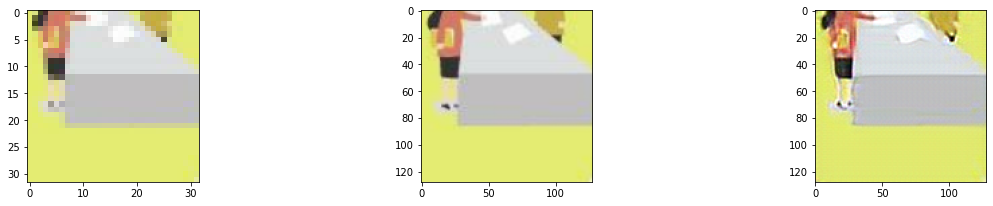

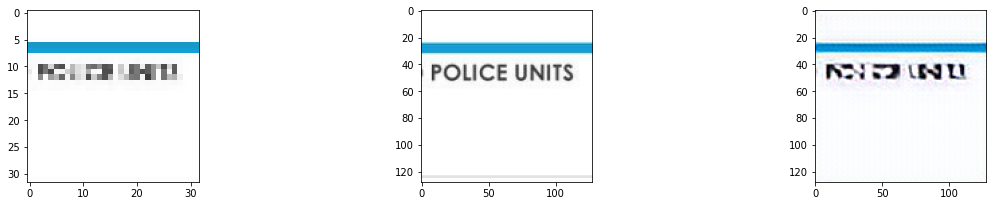

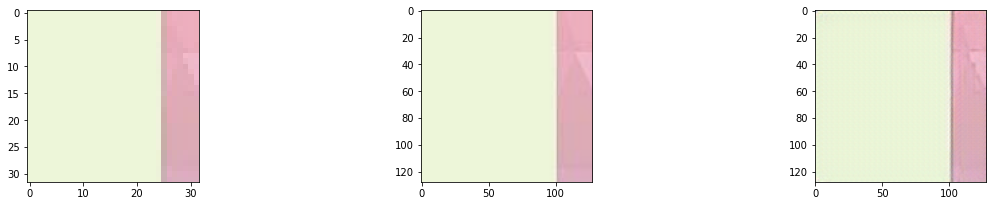

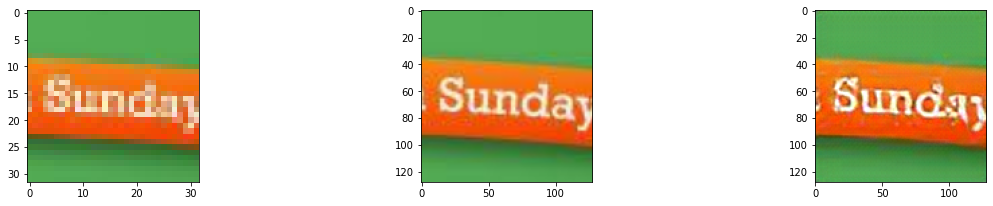

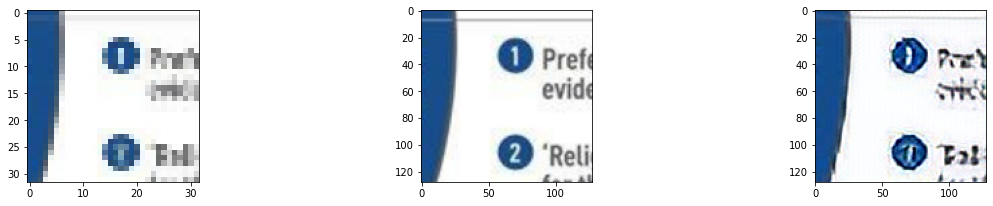

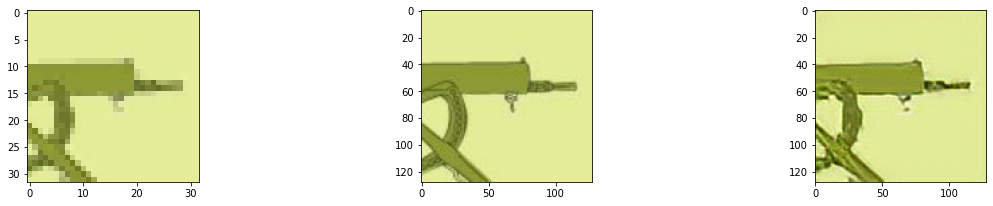

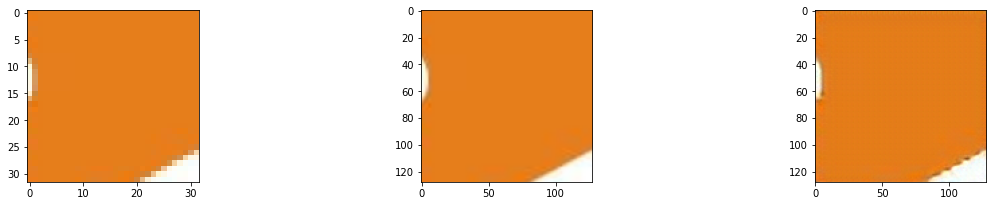

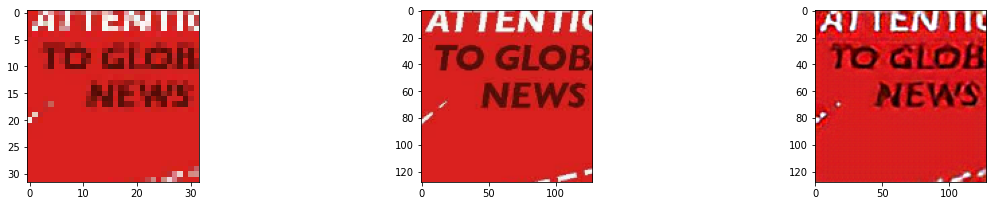

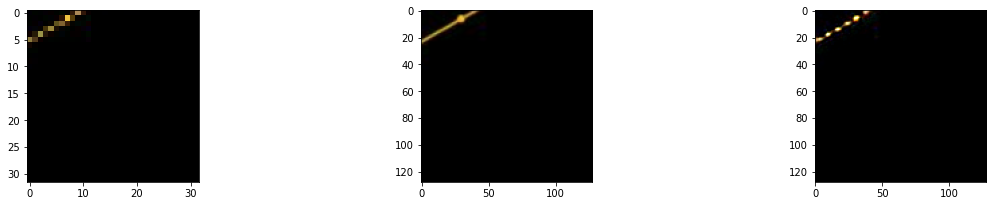

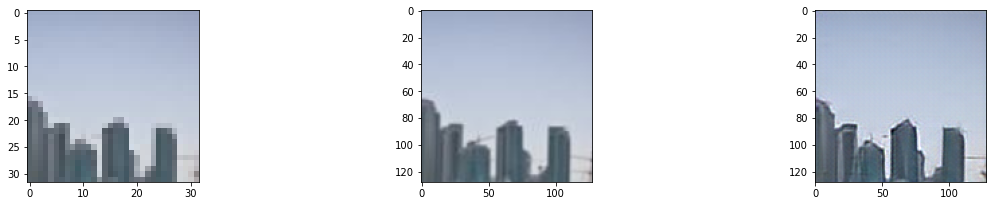

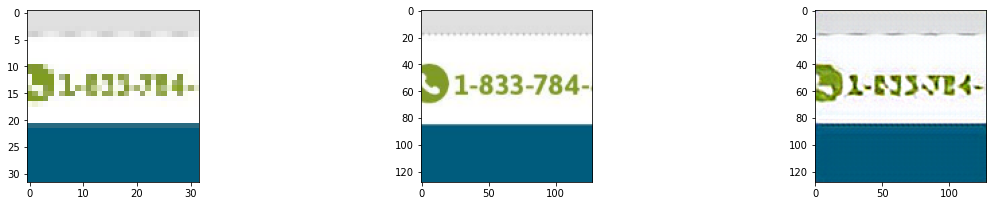

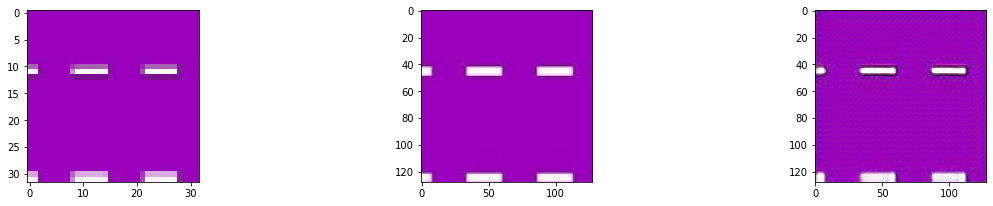

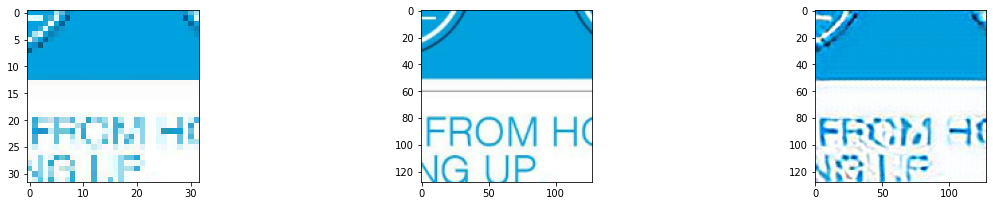

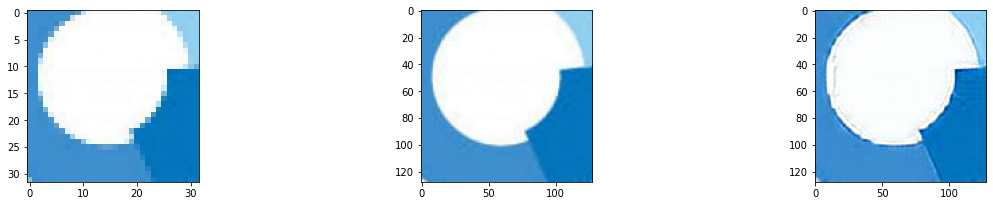

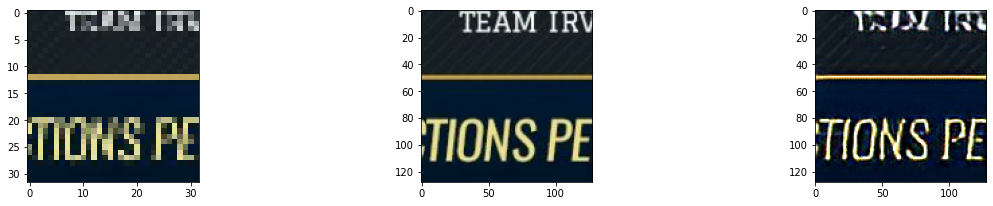

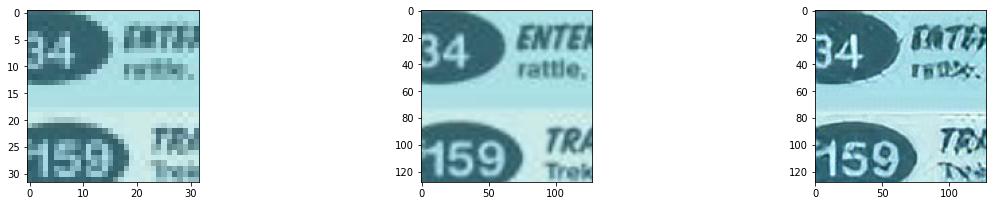

In [9]:
lr, hr = test_iterator.next()
sr = test_model(lr)
for i in range(batch_size):
    fig = plt.figure(figsize=(20, 60))
    plt.subplot(batch_size, 3, i*3 + 1)
    plt.imshow(tf.cast(lr[i], tf.uint8))
    plt.subplot(batch_size, 3, i*3 + 2)
    plt.imshow(tf.cast(hr[i], tf.uint8))
    plt.subplot(batch_size, 3, i*3 + 3)
    plt.imshow(tf.cast(tf.squeeze(tf.clip_by_value(sr[i], 0, 255)), tf.uint8))
    plt.savefig("./before/sample_images/batch.png")

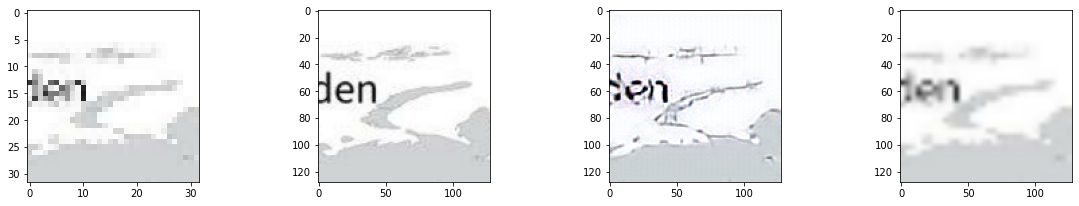

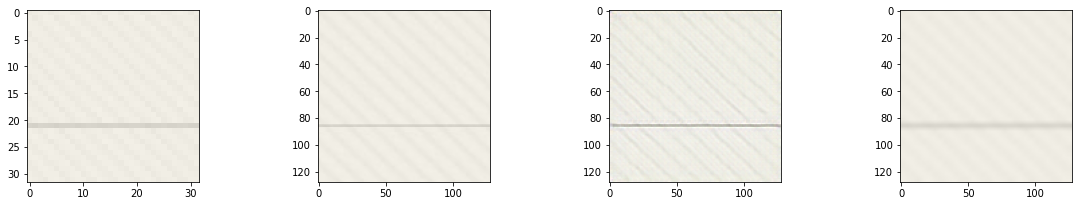

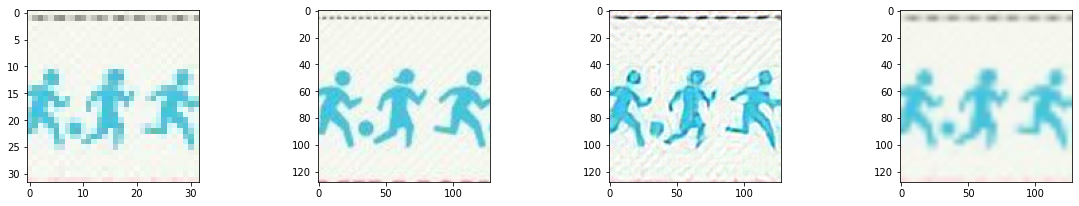

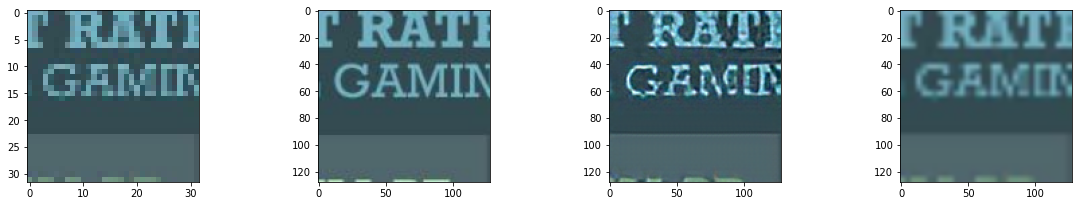

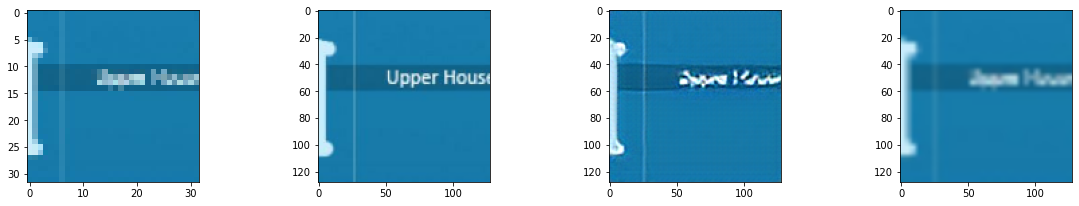

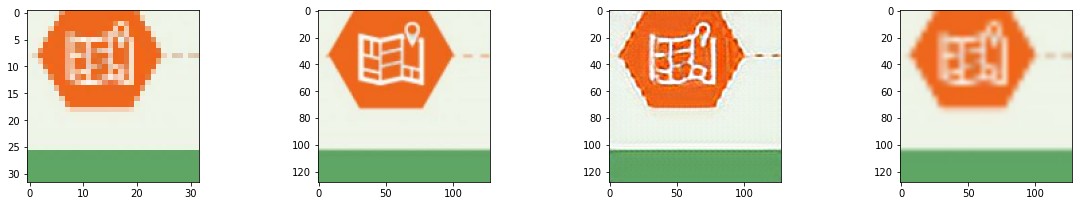

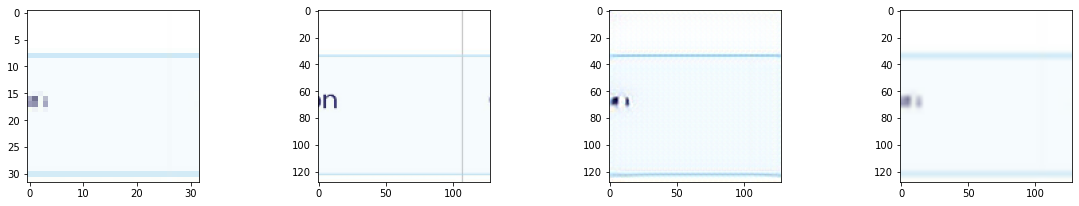

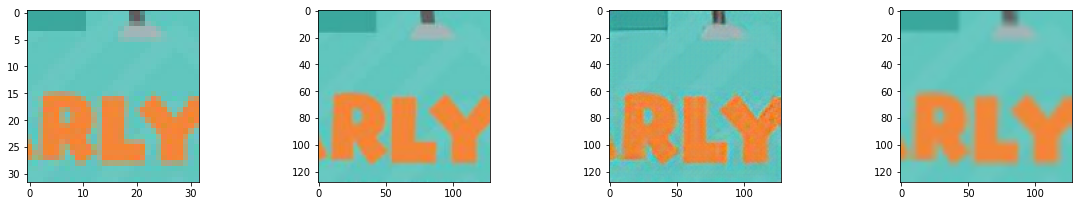

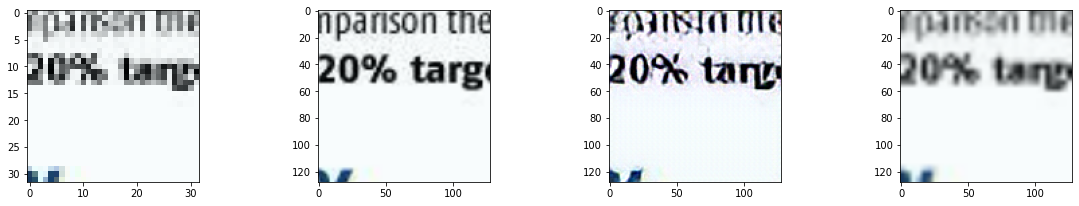

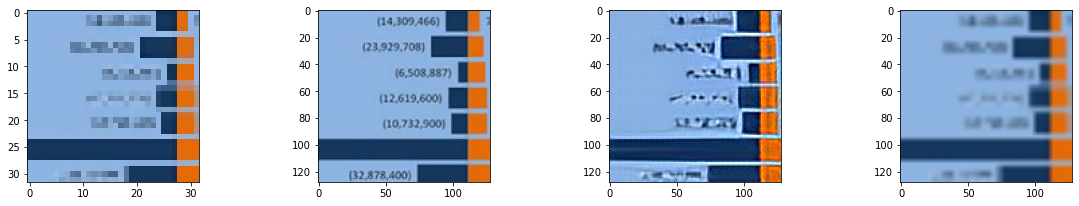

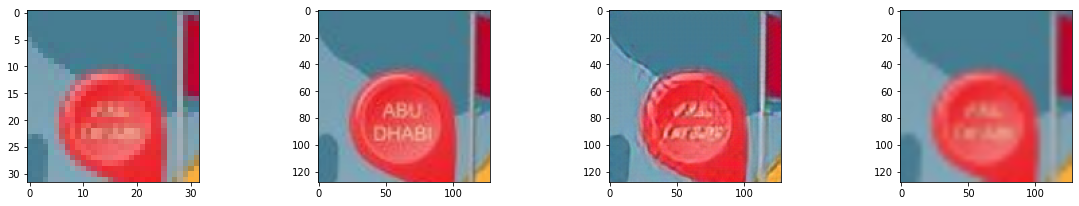

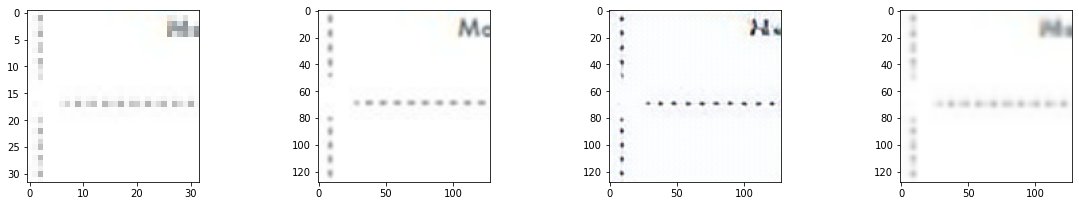

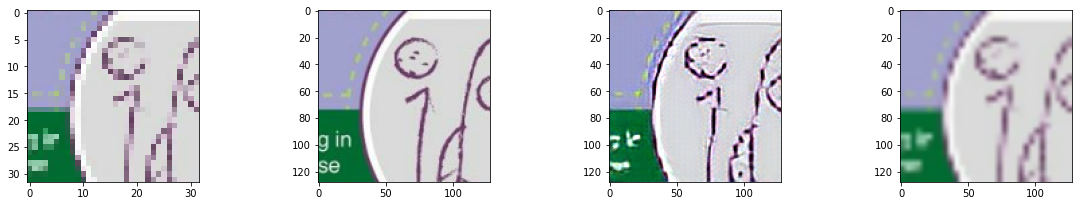

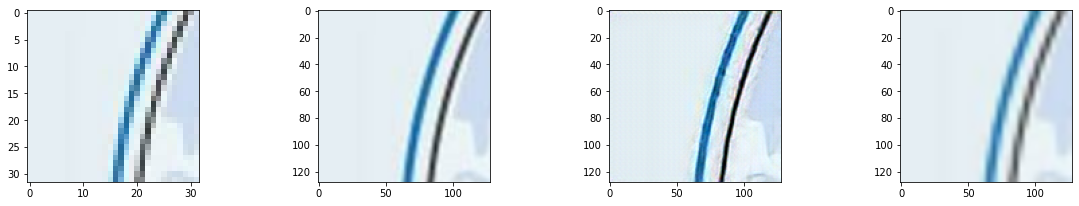

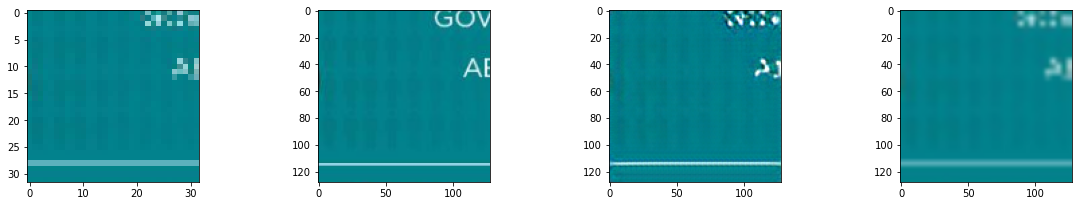

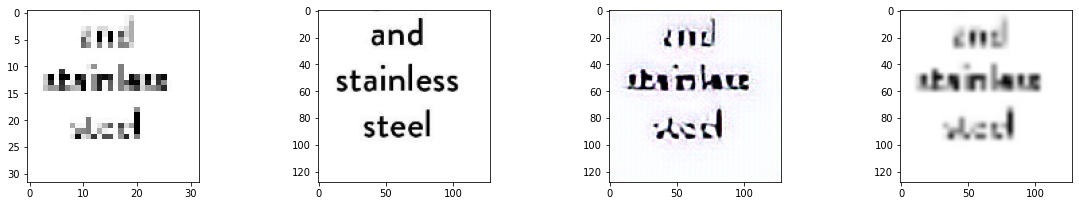

In [10]:
lr, hr = test_iterator.next()
sr = test_model(lr)
for i in range(batch_size):
    new_image = tf.image.resize(lr, list(hr_shape))
    fig = plt.figure(figsize=(20, 60))
    plt.subplot(batch_size, 4, i*4 + 1)
    plt.imshow(tf.cast(lr[i], tf.uint8))
    plt.subplot(batch_size, 4, i*4 + 2)
    plt.imshow(tf.cast(hr[i], tf.uint8))
    plt.subplot(batch_size, 4, i*4 + 3)
    plt.imshow(tf.cast(tf.squeeze(tf.clip_by_value(sr[i], 0, 255)), tf.uint8))
    plt.subplot(batch_size, 4, i*4 + 4)
    plt.imshow(tf.cast(new_image[i], tf.uint8))

In [11]:
def perceptualLoss(weights=None, input_shape=None):
    vgg_model = tf.keras.applications.vgg19.VGG19(input_shape=input_shape, weights=weights, include_top=False)
    for layer in vgg_model.layers:
        layer.trainable = False
    vgg_model.get_layer("block5_conv4").activation = lambda x: x
    feat_ext = tf.keras.Model(
      inputs=[vgg_model.input],
      outputs=[vgg_model.get_layer("block5_conv4").output])

    def loss(y_true, y_pred):
        return tf.compat.v1.losses.absolute_difference(feat_ext(y_true), feat_ext(y_pred))
    return loss

def pixel_loss(y_true, y_pred):
      return tf.reduce_mean(tf.reduce_mean(tf.abs(y_true - y_pred), axis=0))

def relativisticAverageLoss(disc, type_="G"):
    loss = {}

    def loss_D(y_true, y_pred):

        rlog = disc(y_true) - tf.reduce_mean(disc(y_pred))
        flog = disc(y_pred) - tf.reduce_mean(disc(y_true))
        real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(rlog), logits=rlog))
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(flog), logits=flog))
        return real_loss + fake_loss

    def loss_G(y_true, y_pred):
        rlog = disc(y_true) - tf.reduce_mean(disc(y_pred))
        flog = disc(y_pred) - tf.reduce_mean(disc(y_true))
        real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(rlog), logits=rlog)
        fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(flog), logits=flog)
        return real_loss + fake_loss

    loss["G"] = loss_G
    loss["D"] = loss_D  
    return loss[type_]

In [12]:
class Discriminator(tf.keras.Model):
      
    def __init__(self, batch_size=16):
        super(Discriminator, self).__init__()
    
        def conv(filters, strides, use_bias=False):
            return tf.keras.layers.Conv2D(filters=filters, kernel_size=[3, 3], strides=strides, use_bias=use_bias, padding="same")

        self.lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
    
        self.conv01 = conv(filters=64, strides=1)    
        self.conv02 = conv(filters=64, strides=2)
        self.batch_norm02 = tf.keras.layers.BatchNormalization()

        self.conv11 = conv(filters=128, strides=1)
        self.batch_norm11 = tf.keras.layers.BatchNormalization()
        self.conv12 = conv(filters=128, strides=2)
        self.batch_norm12 = tf.keras.layers.BatchNormalization()

        self.conv21 = conv(filters=256, strides=1)
        self.batch_norm21 = tf.keras.layers.BatchNormalization()
        self.conv22 = conv(filters=256, strides=2)
        self.batch_norm22 = tf.keras.layers.BatchNormalization()
        
        self.conv31 = conv(filters=512, strides=1)
        self.batch_norm31 = tf.keras.layers.BatchNormalization()
        self.conv32 = conv(filters=512, strides=2)
        self.batch_norm32 = tf.keras.layers.BatchNormalization()

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(100)
        self.dense2 = tf.keras.layers.Dense(1)
    
    def call(self, input_images):

        feat = self.lrelu(self.conv01(input_images))
        feat = self.lrelu(self.batch_norm02(self.conv02(feat)))
        feat = self.lrelu(self.batch_norm11(self.conv11(feat)))
        feat = self.lrelu(self.batch_norm12(self.conv12(feat)))

        feat = self.lrelu(self.batch_norm21(self.conv21(feat)))
        feat = self.lrelu(self.batch_norm22(self.conv22(feat)))

        feat = self.lrelu(self.batch_norm31(self.conv31(feat)))
        feat = self.lrelu(self.batch_norm32(self.conv32(feat)))

        flatten = self.flatten(feat)
        dense = self.dense1(flatten)
        out = self.dense2(dense)

        return out

In [13]:
pretrained_generator = hub.KerasLayer(MODEL_PATH, trainable=True)

In [14]:
pretrained_generator.get_config()

{'name': 'keras_layer_1',
 'trainable': True,
 'dtype': 'float32',
 'handle': 'https://tfhub.dev/captain-pool/esrgan-tf2/1'}

In [15]:
generator = Sequential([
    pretrained_generator,
])

In [16]:
discriminator = Discriminator(batch_size=batch_size)

In [17]:
# generator.summary()
input_shape = tuple([1] + list(lr_shape) + [3]) 
print(input_shape)
generator.build(input_shape=input_shape)
generator.summary()

(1, 32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (1, 128, 128, 3)          4605955   
Total params: 4,605,955
Trainable params: 4,605,955
Non-trainable params: 0
_________________________________________________________________


In [18]:
discriminator.build(input_shape=generator.output_shape)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36864     
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73728     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                

In [19]:
optimizer_G = tf.optimizers.Adam(learning_rate=lr_g, beta_1=b1, beta_2=b2)
optimizer_D = tf.optimizers.Adam(learning_rate=lr_d, beta_1=b1, beta_2=b2)

criterion_G = relativisticAverageLoss(discriminator, type_="G")
criterion_D = relativisticAverageLoss(discriminator, type_="D")

checkpoint = tf.train.Checkpoint(G=generator, G_optimizer=optimizer_G, D=discriminator, D_optimizer=optimizer_D)

In [20]:
gen_met = tf.keras.metrics.Mean()
disc_met = tf.keras.metrics.Mean()
psnr_met = tf.keras.metrics.Mean()
ssim_met = tf.keras.metrics.Mean()
perceptual_loss = perceptualLoss(weights="imagenet", input_shape=list(hr_shape).append(3))

80150528/80134624 [==============================] - 0s 0us/step


In [21]:
def pre_process(image):
#     image = tf.expand_dims(image, -1)
    image = tf.cast(image, tf.float32)
    mean = tf.constant([123.0, 123.0, 123.0])
    return tf.nn.bias_add(image, -mean)

def step_fn(image_lr, image_hr, batch_size):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
#         print("-"*20)
#         print("Initiating step\nNormalizing images, generating fakes")
        fake = generator(image_lr)
        fake = pre_process(fake)
        image_lr = pre_process(image_lr)
        image_hr = pre_process(image_hr)
#         print("Calculating Loss")
        loss_percep = tf.reduce_mean(perceptual_loss(image_hr, fake))
        loss_l1 = pixel_loss(image_hr, fake)

        loss_rag_g = relativisticAverageLoss(discriminator, type_="G")(image_hr, fake)
        loss_rag_d = relativisticAverageLoss(discriminator, type_="D")(image_hr, fake)

        gen_loss = 0
        gen_loss += PL_COEFF * loss_percep
        gen_loss += RAGL_COEFF * loss_rag_g
        gen_loss += CL_COEFF * loss_l1
        disc_loss = RAGL_COEFF * loss_rag_d
        disc_met(disc_loss)
        gen_met(gen_loss)
        
        gen_loss *= (1.0 / batch_size)
        disc_loss *= (1.0 / batch_size)
        psnr_met(tf.reduce_mean(tf.image.psnr(fake, image_hr, max_val = 256.0)))
        ssim_met(tf.reduce_mean(tf.image.ssim(fake, image_hr, max_val = 256.0)))
#     print("Activating Optimizers")
    d_grad = d_tape.gradient(disc_loss, discriminator.trainable_variables)
    optimizer_D.apply_gradients(zip(d_grad, discriminator.trainable_variables))
    
    g_grad = g_tape.gradient(gen_loss, generator.trainable_variables)
    optimizer_G.apply_gradients(zip(g_grad, generator.trainable_variables))

    return gen_met, disc_met, psnr_met, ssim_met

In [22]:
def test_model_fn(epoch, test_iterator=test_iterator, save=False):
    psnr_pre = []
    psnr_post = []
    ssim_pre = []
    ssim_post = []
    pre_pl = []
    post_pl = []
    for bno, batch in enumerate(test_iterator):
        lr, hr = batch
        sr_posttrain = generator(lr)
        sr_pretrain = test_model(lr)
        if save:
            fig = plt.figure(figsize=(5, 5))
            plt.subplot(2, 2, 1)
            plt.imshow(tf.cast(lr[0], tf.uint8))
            plt.subplot(2, 2, 2)
            plt.imshow(tf.cast(hr[0], tf.uint8))
            plt.subplot(2, 2, 3)
            plt.imshow(tf.cast(tf.squeeze(tf.clip_by_value(sr_posttrain[0], 0, 255)), tf.uint8))
            plt.subplot(2, 2, 4)
            plt.imshow(tf.cast(tf.squeeze(tf.clip_by_value(sr_pretrain[0], 0, 255)), tf.uint8))
            plt.savefig("./results/images/batch_{}_e{}.png".format(bno, epoch))
            plt.close()

        fake_pretrain = pre_process(sr_pretrain)
        fake_posttrain = pre_process(sr_posttrain)
        psnr_met(tf.reduce_mean(tf.image.psnr(fake_pretrain, hr, max_val = 256.0)))
        ssim_met(tf.reduce_mean(tf.image.ssim(fake_pretrain, hr, max_val = 256.0)))
        psnr_pre.append(psnr_met.result().numpy())
        ssim_pre.append(ssim_met.result().numpy())
        psnr_met(tf.reduce_mean(tf.image.psnr(fake_posttrain, hr, max_val = 256.0)))
        ssim_met(tf.reduce_mean(tf.image.ssim(fake_posttrain, hr, max_val = 256.0)))
        psnr_post.append(psnr_met.result().numpy())
        ssim_post.append(ssim_met.result().numpy())
        
        pre_pl.append(tf.reduce_mean(perceptual_loss(hr, fake_pretrain)))
        post_pl.append(tf.reduce_mean(perceptual_loss(hr, fake_posttrain)))

    psnr_pre = np.mean(np.array(psnr_pre))
    psnr_post = np.mean(np.array(psnr_post))
    ssim_pre = np.mean(np.array(ssim_pre))
    ssim_post = np.mean(np.array(ssim_post))
    pre_pl = np.mean(pre_pl)
    post_pl = np.mean(post_pl)
    print("PSNR(pre) = {}\nPSNR(post) = {}\n\nSSIM(pre) = {}\nSSIM(post) = {}\n\nPerceptual Loss(pre) = {}\nPerceptual Loss(post) = {}\n\n"
          .format(psnr_pre, psnr_post, ssim_pre, ssim_post, pre_pl, post_pl))

In [23]:
start = time.time()
final_psnr = 0

train_iterator, test_iterator = reset_iterator()
checkpoint = tf.train.Checkpoint(G=generator, optimizer_G=optimizer_G, D=discriminator, optimizer_D=optimizer_D)

dataset = train_dataset
test_model_fn("00", test_iterator)

for epoch in range(max_epoch):
    train_iterator, test_iterator = reset_iterator()
    print("-"*20)
    print("Epoch {} / {}".format(epoch, max_epoch))
    print("-"*20)
    for step, batch in enumerate(train_iterator):
        image_lr, image_hr = batch

        gen_met, disc_met, psnr_met, ssim_met = step_fn(image_lr, image_hr, batch_size = batch_size)
        if step % 8 == 0:
            print("|---")
            print("{}s :- {}/{} batches:\n Gen loss: {},\n Disc loss: {}\n PSNR: {}\n SSIM: {}\n".format(np.round(time.time()-start, 1), step, len(train_dataset), gen_met.result(), disc_met.result(), psnr_met.result(), ssim_met.result()))
    if epoch == (max_epoch - 1):
        final_psnr = psnr_met

    if ((epoch+1) % 5) == 0 or epoch == 0: 
        test_model_fn(str(epoch), test_iterator)

train_iterator, test_iterator = reset_iterator()
test_model_fn(str("End"), test_iterator, save=True)
print("Training Completed!\n Final PSNR: {}".format(final_psnr))
print("Saving Checkpoint...")
generator.save(CHECKPOINT_PATH+"generator_e{}.h5".format(str(epoch)))


PSNR(pre) = 6.080221652984619
PSNR(post) = 6.080173492431641

SSIM(pre) = 0.23401983082294464
SSIM(post) = 0.23494097590446472

Perceptual Loss(pre) = 20.883028030395508
Perceptual Loss(post) = 20.883026123046875


--------------------
Epoch 0 / 20
--------------------


2021-12-02 11:26:02.957976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 9 of 24
2021-12-02 11:26:14.148573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18 of 24
2021-12-02 11:26:19.363090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
99.1s :- 0/238 batches:
 Gen loss: 0.12156610190868378,
 Disc loss: 0.008045174181461334
 PSNR: 6.293613910675049
 SSIM: 0.2608775198459625

|---
106.4s :- 8/238 batches:
 Gen loss: 0.1210089921951294,
 Disc loss: 0.008764570578932762
 PSNR: 7.861391544342041
 SSIM: 0.30830118060112

|---
115.9s :- 16/238 batches:
 Gen loss: 0.10838968306779861,
 Disc loss: 0.007906435988843441
 PSNR: 9.314805030822754
 SSIM: 0.35078367590904236

|---
126.6s :- 24/238 batches:
 Gen loss: 0.10218348354101181,
 Disc loss: 0.00754541577771306
 PSNR: 10.61182689666748
 SSIM: 0.3873423635959625

|---
135.2s :- 32/238 batches:
 Gen loss: 0.09869105368852615,
 Disc loss: 0.007316951174288988
 PSNR: 11.675552368164062
 SSIM: 0.41889840364456177

|---
145.3s :- 40/238 batches:
 Gen loss: 0.09521990269422531,
 Disc loss: 0.007210019044578075
 PSNR: 12.712250709533691
 SSIM: 0.44743284583091736

|---
156.8s :- 48/238 batches:
 Gen loss: 0.09378411620855331,
 Disc loss: 0.007011121604591608
 PSNR: 13.55038738

2021-12-02 11:33:41.234810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 11:33:49.550165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 21 of 24
2021-12-02 11:33:52.088368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
524.9s :- 0/238 batches:
 Gen loss: 0.0918118953704834,
 Disc loss: 0.005221724044531584
 PSNR: 18.307016372680664
 SSIM: 0.6112073659896851

|---
532.6s :- 8/238 batches:
 Gen loss: 0.09223335236310959,
 Disc loss: 0.005144353490322828
 PSNR: 18.470809936523438
 SSIM: 0.615867018699646

|---
541.7s :- 16/238 batches:
 Gen loss: 0.09219834208488464,
 Disc loss: 0.005111697595566511
 PSNR: 18.635841369628906
 SSIM: 0.6205213665962219

|---
551.1s :- 24/238 batches:
 Gen loss: 0.09248746186494827,
 Disc loss: 0.005059701856225729
 PSNR: 18.797870635986328
 SSIM: 0.6249315142631531

|---
558.4s :- 32/238 batches:
 Gen loss: 0.09260866045951843,
 Disc loss: 0.005063852295279503
 PSNR: 18.935731887817383
 SSIM: 0.6290746331214905

|---
568.0s :- 40/238 batches:
 Gen loss: 0.09203405678272247,
 Disc loss: 0.005077316425740719
 PSNR: 19.101337432861328
 SSIM: 0.6332213282585144

|---
578.5s :- 48/238 batches:
 Gen loss: 0.09165431559085846,
 Disc loss: 0.005050466395914555
 PSNR: 19.2649

2021-12-02 11:38:23.600933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 11:38:32.561802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 11:38:34.162401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
807.0s :- 0/238 batches:
 Gen loss: 0.0934673622250557,
 Disc loss: 0.0045403470285236835
 PSNR: 21.404518127441406
 SSIM: 0.7002383470535278

|---
814.5s :- 8/238 batches:
 Gen loss: 0.09346852451562881,
 Disc loss: 0.00451440317556262
 PSNR: 21.465715408325195
 SSIM: 0.7021061778068542

|---
822.7s :- 16/238 batches:
 Gen loss: 0.09389864653348923,
 Disc loss: 0.004467793274670839
 PSNR: 21.518421173095703
 SSIM: 0.7036291360855103

|---
832.3s :- 24/238 batches:
 Gen loss: 0.09407847374677658,
 Disc loss: 0.00444401940330863
 PSNR: 21.574228286743164
 SSIM: 0.7052431106567383

|---
840.0s :- 32/238 batches:
 Gen loss: 0.0940837487578392,
 Disc loss: 0.004417059477418661
 PSNR: 21.632871627807617
 SSIM: 0.7069545984268188

|---
848.8s :- 40/238 batches:
 Gen loss: 0.09424460679292679,
 Disc loss: 0.004395587835460901
 PSNR: 21.68502426147461
 SSIM: 0.7084944844245911

|---
859.7s :- 48/238 batches:
 Gen loss: 0.09440229088068008,
 Disc loss: 0.004372501280158758
 PSNR: 21.738866

2021-12-02 11:43:01.685065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 11:43:10.541872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 11:43:12.161738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
1085.3s :- 0/238 batches:
 Gen loss: 0.10019569844007492,
 Disc loss: 0.0035829986445605755
 PSNR: 22.765399932861328
 SSIM: 0.7392728328704834

|---
1093.0s :- 8/238 batches:
 Gen loss: 0.10057082772254944,
 Disc loss: 0.003549387911334634
 PSNR: 22.799341201782227
 SSIM: 0.7402462959289551

|---
1101.4s :- 16/238 batches:
 Gen loss: 0.10100177675485611,
 Disc loss: 0.003514613024890423
 PSNR: 22.82400894165039
 SSIM: 0.7410377860069275

|---
1110.7s :- 24/238 batches:
 Gen loss: 0.10153011977672577,
 Disc loss: 0.003481006482616067
 PSNR: 22.8492374420166
 SSIM: 0.7418702840805054

|---
1118.8s :- 32/238 batches:
 Gen loss: 0.1022205501794815,
 Disc loss: 0.003452831879258156
 PSNR: 22.868629455566406
 SSIM: 0.742605447769165

|---
1127.6s :- 40/238 batches:
 Gen loss: 0.10269266366958618,
 Disc loss: 0.0034229913726449013
 PSNR: 22.896102905273438
 SSIM: 0.7434317469596863

|---
1138.0s :- 48/238 batches:
 Gen loss: 0.10303906351327896,
 Disc loss: 0.0033899396657943726
 PSNR: 

2021-12-02 11:48:23.528575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 11:48:32.509829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 11:48:34.276974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
1407.3s :- 0/238 batches:
 Gen loss: 0.11195680499076843,
 Disc loss: 0.002814648672938347
 PSNR: 23.485090255737305
 SSIM: 0.7601233720779419

|---
1415.4s :- 8/238 batches:
 Gen loss: 0.11223214119672775,
 Disc loss: 0.002796716522425413
 PSNR: 23.508638381958008
 SSIM: 0.7607280611991882

|---
1425.1s :- 16/238 batches:
 Gen loss: 0.11236929148435593,
 Disc loss: 0.00278023281134665
 PSNR: 23.532320022583008
 SSIM: 0.761334240436554

|---
1434.6s :- 24/238 batches:
 Gen loss: 0.1125837117433548,
 Disc loss: 0.002771518426015973
 PSNR: 23.554752349853516
 SSIM: 0.761864960193634

|---
1442.9s :- 32/238 batches:
 Gen loss: 0.112734854221344,
 Disc loss: 0.002756536938250065
 PSNR: 23.578392028808594
 SSIM: 0.7624363303184509

|---
1451.1s :- 40/238 batches:
 Gen loss: 0.11302940547466278,
 Disc loss: 0.0027371456380933523
 PSNR: 23.595243453979492
 SSIM: 0.762953519821167

|---
1461.2s :- 48/238 batches:
 Gen loss: 0.11320547014474869,
 Disc loss: 0.002717614872381091
 PSNR: 23.6

2021-12-02 11:53:34.467579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 11:53:43.033467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 11:53:44.782645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
1717.6s :- 0/238 batches:
 Gen loss: 0.11710037291049957,
 Disc loss: 0.002401102799922228
 PSNR: 23.046438217163086
 SSIM: 0.7466446757316589

|---
1724.7s :- 8/238 batches:
 Gen loss: 0.11724255234003067,
 Disc loss: 0.0023894868791103363
 PSNR: 23.063961029052734
 SSIM: 0.7471504807472229

|---
1733.4s :- 16/238 batches:
 Gen loss: 0.11749113351106644,
 Disc loss: 0.0023767268285155296
 PSNR: 23.07952117919922
 SSIM: 0.7475753426551819

|---
1743.0s :- 24/238 batches:
 Gen loss: 0.11764171719551086,
 Disc loss: 0.002366219414398074
 PSNR: 23.10213851928711
 SSIM: 0.7481550574302673

|---
1751.6s :- 32/238 batches:
 Gen loss: 0.1177644431591034,
 Disc loss: 0.0023547664750367403
 PSNR: 23.11901092529297
 SSIM: 0.7486343383789062

|---
1759.7s :- 40/238 batches:
 Gen loss: 0.11794336885213852,
 Disc loss: 0.002342388266697526
 PSNR: 23.138940811157227
 SSIM: 0.7491776347160339

|---
1770.2s :- 48/238 batches:
 Gen loss: 0.11818081885576248,
 Disc loss: 0.0023290757089853287
 PSNR

2021-12-02 11:58:14.416184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 11:58:23.580701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 11:58:25.263988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
1998.1s :- 0/238 batches:
 Gen loss: 0.12235169112682343,
 Disc loss: 0.002103205770254135
 PSNR: 23.52928924560547
 SSIM: 0.7598425149917603

|---
2005.5s :- 8/238 batches:
 Gen loss: 0.12243818491697311,
 Disc loss: 0.0021522631868720055
 PSNR: 23.54351806640625
 SSIM: 0.7602822780609131

|---
2013.9s :- 16/238 batches:
 Gen loss: 0.12238714098930359,
 Disc loss: 0.0022612314205616713
 PSNR: 23.5614070892334
 SSIM: 0.7606929540634155

|---
2023.1s :- 24/238 batches:
 Gen loss: 0.12226520478725433,
 Disc loss: 0.0022589436266571283
 PSNR: 23.5770320892334
 SSIM: 0.7610947489738464

|---
2031.5s :- 32/238 batches:
 Gen loss: 0.1222432553768158,
 Disc loss: 0.0022526332177221775
 PSNR: 23.587566375732422
 SSIM: 0.7614879608154297

|---
2040.4s :- 40/238 batches:
 Gen loss: 0.12218858301639557,
 Disc loss: 0.002249412937089801
 PSNR: 23.59946060180664
 SSIM: 0.7618708610534668

|---
2050.6s :- 48/238 batches:
 Gen loss: 0.1221136525273323,
 Disc loss: 0.0022450098767876625
 PSNR: 23

2021-12-02 12:02:54.287488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:03:03.886932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:03:04.668812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
2277.6s :- 0/238 batches:
 Gen loss: 0.12457087635993958,
 Disc loss: 0.0020715121645480394
 PSNR: 23.89641761779785
 SSIM: 0.7706692218780518

|---
2285.1s :- 8/238 batches:
 Gen loss: 0.12464474141597748,
 Disc loss: 0.002064254367724061
 PSNR: 23.906980514526367
 SSIM: 0.7709552049636841

|---
2293.7s :- 16/238 batches:
 Gen loss: 0.1247316226363182,
 Disc loss: 0.002056183060631156
 PSNR: 23.91750144958496
 SSIM: 0.7712720036506653

|---
2303.0s :- 24/238 batches:
 Gen loss: 0.12483189254999161,
 Disc loss: 0.00205001188442111
 PSNR: 23.925922393798828
 SSIM: 0.7715564966201782

|---
2310.1s :- 32/238 batches:
 Gen loss: 0.12496268004179001,
 Disc loss: 0.0020444069523364305
 PSNR: 23.938621520996094
 SSIM: 0.7718981504440308

|---
2319.1s :- 40/238 batches:
 Gen loss: 0.12508417665958405,
 Disc loss: 0.002036942634731531
 PSNR: 23.950912475585938
 SSIM: 0.7722282409667969

|---
2330.2s :- 48/238 batches:
 Gen loss: 0.12521691620349884,
 Disc loss: 0.002039610641077161
 PSNR: 

2021-12-02 12:07:31.705198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:07:41.469740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:07:42.173834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
2555.8s :- 0/238 batches:
 Gen loss: 0.12719057500362396,
 Disc loss: 0.0019019813043996692
 PSNR: 24.171764373779297
 SSIM: 0.7789696455001831

|---
2562.7s :- 8/238 batches:
 Gen loss: 0.12724554538726807,
 Disc loss: 0.001896184985525906
 PSNR: 24.181655883789062
 SSIM: 0.7792549729347229

|---
2571.4s :- 16/238 batches:
 Gen loss: 0.12730519473552704,
 Disc loss: 0.0018922558519989252
 PSNR: 24.189809799194336
 SSIM: 0.7795056104660034

|---
2581.2s :- 24/238 batches:
 Gen loss: 0.12747980654239655,
 Disc loss: 0.0018857150571420789
 PSNR: 24.197803497314453
 SSIM: 0.7797569036483765

|---
2589.6s :- 32/238 batches:
 Gen loss: 0.12756335735321045,
 Disc loss: 0.0018821858102455735
 PSNR: 24.204641342163086
 SSIM: 0.7800023555755615

|---
2599.4s :- 40/238 batches:
 Gen loss: 0.12765634059906006,
 Disc loss: 0.0018761350074782968
 PSNR: 24.214004516601562
 SSIM: 0.780245304107666

|---
2610.4s :- 48/238 batches:
 Gen loss: 0.12774871289730072,
 Disc loss: 0.0018702939851209521


2021-12-02 12:12:13.092807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:12:22.620992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:12:23.348522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
2836.3s :- 0/238 batches:
 Gen loss: 0.13125403225421906,
 Disc loss: 0.0017519232351332903
 PSNR: 24.38045310974121
 SSIM: 0.7850924730300903

|---
2843.8s :- 8/238 batches:
 Gen loss: 0.13132557272911072,
 Disc loss: 0.001747842412441969
 PSNR: 24.38680648803711
 SSIM: 0.7852599024772644

|---
2853.0s :- 16/238 batches:
 Gen loss: 0.1314231902360916,
 Disc loss: 0.001743049593642354
 PSNR: 24.39322853088379
 SSIM: 0.7854620814323425

|---
2862.0s :- 24/238 batches:
 Gen loss: 0.13150976598262787,
 Disc loss: 0.0017392620211467147
 PSNR: 24.401222229003906
 SSIM: 0.7856696248054504

|---
2868.8s :- 32/238 batches:
 Gen loss: 0.1316356509923935,
 Disc loss: 0.001733621465973556
 PSNR: 24.407867431640625
 SSIM: 0.7858728766441345

|---
2877.0s :- 40/238 batches:
 Gen loss: 0.1318686455488205,
 Disc loss: 0.001728544128127396
 PSNR: 24.41092300415039
 SSIM: 0.7859510779380798

|---
2887.3s :- 48/238 batches:
 Gen loss: 0.13200661540031433,
 Disc loss: 0.0017272039549425244
 PSNR: 24

2021-12-02 12:17:20.937097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:17:29.957842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 12:17:31.597372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
3145.5s :- 0/238 batches:
 Gen loss: 0.13512840867042542,
 Disc loss: 0.001626319601200521
 PSNR: 24.0280704498291
 SSIM: 0.7755327224731445

|---
3153.6s :- 8/238 batches:
 Gen loss: 0.13531868159770966,
 Disc loss: 0.0016220733523368835
 PSNR: 24.033306121826172
 SSIM: 0.7757054567337036

|---
3161.9s :- 16/238 batches:
 Gen loss: 0.13545382022857666,
 Disc loss: 0.001617938163690269
 PSNR: 24.038299560546875
 SSIM: 0.775857150554657

|---
3171.0s :- 24/238 batches:
 Gen loss: 0.13559529185295105,
 Disc loss: 0.001613590051420033
 PSNR: 24.048080444335938
 SSIM: 0.776044487953186

|---
3178.2s :- 32/238 batches:
 Gen loss: 0.13575036823749542,
 Disc loss: 0.0016089205164462328
 PSNR: 24.05618667602539
 SSIM: 0.7762218117713928

|---
3187.8s :- 40/238 batches:
 Gen loss: 0.13587018847465515,
 Disc loss: 0.0016070633428171277
 PSNR: 24.062623977661133
 SSIM: 0.7764368653297424

|---
3197.9s :- 48/238 batches:
 Gen loss: 0.13600121438503265,
 Disc loss: 0.0016033794963732362
 PSNR:

2021-12-02 12:22:02.926309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:22:11.685520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 12:22:13.289865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
3426.3s :- 0/238 batches:
 Gen loss: 0.13943015038967133,
 Disc loss: 0.0015281676314771175
 PSNR: 24.192934036254883
 SSIM: 0.7799448370933533

|---
3433.5s :- 8/238 batches:
 Gen loss: 0.13949817419052124,
 Disc loss: 0.0015249567804858088
 PSNR: 24.198509216308594
 SSIM: 0.7800965309143066

|---
3441.8s :- 16/238 batches:
 Gen loss: 0.13964678347110748,
 Disc loss: 0.0015211820136755705
 PSNR: 24.205360412597656
 SSIM: 0.7802761197090149

|---
3451.4s :- 24/238 batches:
 Gen loss: 0.13973797857761383,
 Disc loss: 0.0015176857123151422
 PSNR: 24.21053123474121
 SSIM: 0.7804141044616699

|---
3458.9s :- 32/238 batches:
 Gen loss: 0.13982966542243958,
 Disc loss: 0.0015164404176175594
 PSNR: 24.214115142822266
 SSIM: 0.7805530428886414

|---
3468.0s :- 40/238 batches:
 Gen loss: 0.13992053270339966,
 Disc loss: 0.0015129997627809644
 PSNR: 24.22006607055664
 SSIM: 0.7807134985923767

|---
3479.0s :- 48/238 batches:
 Gen loss: 0.14001595973968506,
 Disc loss: 0.0015104655176401138


2021-12-02 12:26:40.565639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:26:50.255213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:26:51.049548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
3704.0s :- 0/238 batches:
 Gen loss: 0.1434454768896103,
 Disc loss: 0.0014384534442797303
 PSNR: 24.341720581054688
 SSIM: 0.7838164567947388

|---
3711.7s :- 8/238 batches:
 Gen loss: 0.14352929592132568,
 Disc loss: 0.001437135972082615
 PSNR: 24.345529556274414
 SSIM: 0.7839200496673584

|---
3720.2s :- 16/238 batches:
 Gen loss: 0.14363959431648254,
 Disc loss: 0.0014350676210597157
 PSNR: 24.350406646728516
 SSIM: 0.7840373516082764

|---
3729.1s :- 24/238 batches:
 Gen loss: 0.1436285376548767,
 Disc loss: 0.001432834891602397
 PSNR: 24.35926628112793
 SSIM: 0.7842116355895996

|---
3736.5s :- 32/238 batches:
 Gen loss: 0.1436895877122879,
 Disc loss: 0.0014299770118668675
 PSNR: 24.365135192871094
 SSIM: 0.7843414545059204

|---
3746.2s :- 40/238 batches:
 Gen loss: 0.14383965730667114,
 Disc loss: 0.0014270773390308022
 PSNR: 24.36905860900879
 SSIM: 0.7844597697257996

|---
3756.5s :- 48/238 batches:
 Gen loss: 0.14394956827163696,
 Disc loss: 0.0014242874458432198
 PSNR

2021-12-02 12:31:19.977128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:31:29.786214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:31:30.585367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
3983.8s :- 0/238 batches:
 Gen loss: 0.1478278934955597,
 Disc loss: 0.0013637066585943103
 PSNR: 24.46925163269043
 SSIM: 0.7871184349060059

|---
3991.1s :- 8/238 batches:
 Gen loss: 0.14790916442871094,
 Disc loss: 0.0013616586802527308
 PSNR: 24.475290298461914
 SSIM: 0.787274956703186

|---
3999.2s :- 16/238 batches:
 Gen loss: 0.14810559153556824,
 Disc loss: 0.001359029090963304
 PSNR: 24.47854995727539
 SSIM: 0.7873755097389221

|---
4008.8s :- 24/238 batches:
 Gen loss: 0.14824876189231873,
 Disc loss: 0.00135631556622684
 PSNR: 24.480512619018555
 SSIM: 0.7874563932418823

|---
4016.4s :- 32/238 batches:
 Gen loss: 0.1483360230922699,
 Disc loss: 0.001353202504105866
 PSNR: 24.485658645629883
 SSIM: 0.7875880002975464

|---
4025.2s :- 40/238 batches:
 Gen loss: 0.14840424060821533,
 Disc loss: 0.0013509703567251563
 PSNR: 24.49232292175293
 SSIM: 0.7877317070960999

|---
4035.3s :- 48/238 batches:
 Gen loss: 0.14860987663269043,
 Disc loss: 0.001348096295259893
 PSNR: 24

2021-12-02 12:35:57.344099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:36:06.533623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:36:07.161558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
4260.0s :- 0/238 batches:
 Gen loss: 0.15156011283397675,
 Disc loss: 0.0012939306907355785
 PSNR: 24.589750289916992
 SSIM: 0.7903227210044861

|---
4267.1s :- 8/238 batches:
 Gen loss: 0.15154065191745758,
 Disc loss: 0.001293605426326394
 PSNR: 24.594144821166992
 SSIM: 0.7904525399208069

|---
4275.6s :- 16/238 batches:
 Gen loss: 0.15156936645507812,
 Disc loss: 0.001291391090489924
 PSNR: 24.598276138305664
 SSIM: 0.7905630469322205

|---
4284.8s :- 24/238 batches:
 Gen loss: 0.1516551971435547,
 Disc loss: 0.0012892972445115447
 PSNR: 24.60387420654297
 SSIM: 0.7906852960586548

|---
4292.1s :- 32/238 batches:
 Gen loss: 0.15173925459384918,
 Disc loss: 0.001286927261389792
 PSNR: 24.607980728149414
 SSIM: 0.790813148021698

|---
4300.1s :- 40/238 batches:
 Gen loss: 0.15182429552078247,
 Disc loss: 0.0012848617043346167
 PSNR: 24.611515045166016
 SSIM: 0.7908889651298523

|---
4310.5s :- 48/238 batches:
 Gen loss: 0.1518438309431076,
 Disc loss: 0.0012829892802983522
 PSNR

2021-12-02 12:41:19.682012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:41:28.531960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 12:41:30.258888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
4583.0s :- 0/238 batches:
 Gen loss: 0.1547585427761078,
 Disc loss: 0.0012463496532291174
 PSNR: 24.345775604248047
 SSIM: 0.7836223244667053

|---
4590.9s :- 8/238 batches:
 Gen loss: 0.15496179461479187,
 Disc loss: 0.0012445654720067978
 PSNR: 24.35091781616211
 SSIM: 0.7837545275688171

|---
4599.6s :- 16/238 batches:
 Gen loss: 0.1550014466047287,
 Disc loss: 0.001244748244062066
 PSNR: 24.35514259338379
 SSIM: 0.7838771343231201

|---
4608.7s :- 24/238 batches:
 Gen loss: 0.15504594147205353,
 Disc loss: 0.0012436246033757925
 PSNR: 24.359451293945312
 SSIM: 0.7839701175689697

|---
4616.0s :- 32/238 batches:
 Gen loss: 0.1550631821155548,
 Disc loss: 0.0012425301829352975
 PSNR: 24.364978790283203
 SSIM: 0.7841078042984009

|---
4625.1s :- 40/238 batches:
 Gen loss: 0.15513744950294495,
 Disc loss: 0.0012409841874614358
 PSNR: 24.36919403076172
 SSIM: 0.784236490726471

|---
4635.8s :- 48/238 batches:
 Gen loss: 0.15526381134986877,
 Disc loss: 0.0012389037292450666
 PSNR:

2021-12-02 12:45:56.134355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:46:05.833413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:46:06.539134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
4859.5s :- 0/238 batches:
 Gen loss: 0.1573410928249359,
 Disc loss: 0.0012007629266008735
 PSNR: 24.45522689819336
 SSIM: 0.7863873839378357

|---
4867.4s :- 8/238 batches:
 Gen loss: 0.1573581099510193,
 Disc loss: 0.0011987773468717933
 PSNR: 24.4609317779541
 SSIM: 0.7864992618560791

|---
4876.4s :- 16/238 batches:
 Gen loss: 0.15743876993656158,
 Disc loss: 0.0011967159807682037
 PSNR: 24.464712142944336
 SSIM: 0.786609411239624

|---
4886.6s :- 24/238 batches:
 Gen loss: 0.15749670565128326,
 Disc loss: 0.0011953060748055577
 PSNR: 24.468441009521484
 SSIM: 0.7867168188095093

|---
4895.3s :- 32/238 batches:
 Gen loss: 0.15752676129341125,
 Disc loss: 0.0011937335366383195
 PSNR: 24.47178077697754
 SSIM: 0.7868166565895081

|---
4905.1s :- 40/238 batches:
 Gen loss: 0.15759822726249695,
 Disc loss: 0.0011921935947611928
 PSNR: 24.47732925415039
 SSIM: 0.786945104598999

|---
4916.5s :- 48/238 batches:
 Gen loss: 0.15768449008464813,
 Disc loss: 0.001190764713101089
 PSNR: 2

2021-12-02 12:51:03.611183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:51:12.817013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 22 of 24
2021-12-02 12:51:14.472885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
5167.3s :- 0/238 batches:
 Gen loss: 0.15903659164905548,
 Disc loss: 0.001152528217062354
 PSNR: 24.548431396484375
 SSIM: 0.7889166474342346

|---
5174.9s :- 8/238 batches:
 Gen loss: 0.15910221636295319,
 Disc loss: 0.0011506823357194662
 PSNR: 24.55093765258789
 SSIM: 0.7889618277549744

|---
5184.1s :- 16/238 batches:
 Gen loss: 0.15916070342063904,
 Disc loss: 0.0011488529853522778
 PSNR: 24.553325653076172
 SSIM: 0.7890304923057556

|---
5193.5s :- 24/238 batches:
 Gen loss: 0.1592613160610199,
 Disc loss: 0.0011468249140307307
 PSNR: 24.556903839111328
 SSIM: 0.7891163229942322

|---
5200.8s :- 32/238 batches:
 Gen loss: 0.15934142470359802,
 Disc loss: 0.001145157148130238
 PSNR: 24.561790466308594
 SSIM: 0.7892208695411682

|---
5209.7s :- 40/238 batches:
 Gen loss: 0.15940633416175842,
 Disc loss: 0.001143396133556962
 PSNR: 24.566469192504883
 SSIM: 0.7893334627151489

|---
5220.8s :- 48/238 batches:
 Gen loss: 0.15954025089740753,
 Disc loss: 0.0011414916953071952
 PS

2021-12-02 12:55:46.610287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 12:55:56.682806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 12:55:57.588156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
5450.4s :- 0/238 batches:
 Gen loss: 0.16094651818275452,
 Disc loss: 0.0011151408543810248
 PSNR: 24.6340274810791
 SSIM: 0.7911292314529419

|---
5458.5s :- 8/238 batches:
 Gen loss: 0.16096368432044983,
 Disc loss: 0.001113391132093966
 PSNR: 24.63777732849121
 SSIM: 0.7912130951881409

|---
5468.4s :- 16/238 batches:
 Gen loss: 0.16101327538490295,
 Disc loss: 0.0011116876266896725
 PSNR: 24.640247344970703
 SSIM: 0.7912892699241638

|---
5479.1s :- 24/238 batches:
 Gen loss: 0.161080002784729,
 Disc loss: 0.0011099019320681691
 PSNR: 24.644229888916016
 SSIM: 0.7913913726806641

|---
5487.4s :- 32/238 batches:
 Gen loss: 0.1611371636390686,
 Disc loss: 0.0011083612916991115
 PSNR: 24.647050857543945
 SSIM: 0.7914748787879944

|---
5495.5s :- 40/238 batches:
 Gen loss: 0.16121327877044678,
 Disc loss: 0.001107100979425013
 PSNR: 24.650453567504883
 SSIM: 0.791589081287384

|---
5505.6s :- 48/238 batches:
 Gen loss: 0.1612452268600464,
 Disc loss: 0.0011059490498155355
 PSNR: 2

2021-12-02 13:00:32.806153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 24
2021-12-02 13:00:42.134165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 24
2021-12-02 13:00:42.831089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


|---
5735.6s :- 0/238 batches:
 Gen loss: 0.1635110080242157,
 Disc loss: 0.0010742514859884977
 PSNR: 24.715190887451172
 SSIM: 0.79326993227005

|---
5743.4s :- 8/238 batches:
 Gen loss: 0.16365091502666473,
 Disc loss: 0.001072729122824967
 PSNR: 24.71765899658203
 SSIM: 0.7933224439620972

|---
5751.0s :- 16/238 batches:
 Gen loss: 0.16385233402252197,
 Disc loss: 0.0010711513459682465
 PSNR: 24.719482421875
 SSIM: 0.7933652997016907

|---
5759.8s :- 24/238 batches:
 Gen loss: 0.16397057473659515,
 Disc loss: 0.0010693528456613421
 PSNR: 24.721561431884766
 SSIM: 0.7934204936027527

|---
5767.4s :- 32/238 batches:
 Gen loss: 0.164132222533226,
 Disc loss: 0.0010701878927648067
 PSNR: 24.723093032836914
 SSIM: 0.7934691309928894

|---
5775.9s :- 40/238 batches:
 Gen loss: 0.1642041653394699,
 Disc loss: 0.001069696038030088
 PSNR: 24.72380828857422
 SSIM: 0.793500542640686

|---
5785.7s :- 48/238 batches:
 Gen loss: 0.16419680416584015,
 Disc loss: 0.0010682163992896676
 PSNR: 24.72